In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 8

In [3]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [7]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
META_FILE = "/home/henryk.michalewski/sat-solving/models/neuropol-18-09-18-002956/model-7268352.meta"
# META_FILE = "/home/henryk.michalewski/sat-solving/models/neuropol-restorer-18-10-09-052043-var-30-lev-30/model.ckpt-3062.meta"
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /home/henryk.michalewski/sat-solving/models/neuropol-18-09-18-002956/model-7268352


In [8]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [9]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [11]:
LEVEL = 20

In [12]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [13]:
np.set_printoptions(precision=3, suppress=True)

In [14]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [15]:
# Because we have to pass full batch

logfile = open("/tmp/log_8_bench", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [16]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e6:
            return None
        
        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [17]:
class ShortCommonDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e6:
            return None
        
        sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [18]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within 1e6 steps solved {} problems out of {}".format(solved, len(sats)))
    return steps, errors

In [19]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [41]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, HybridDPLL)
    compute_and_print_steps(sats, GraphBasedDPLL)
    compute_and_print_steps(sats, ShortCommonDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

  6%|▌         | 6/100 [00:00<00:03, 27.18it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 862.17; stdev step: 499.11; avg error: 7.50; stdev error: 1.88


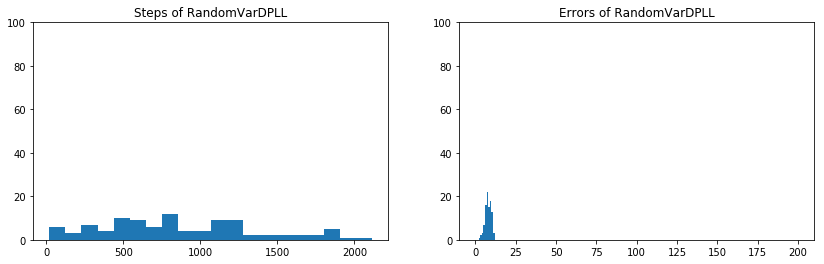

100%|██████████| 100/100 [00:02<00:00, 38.34it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 548.36; stdev step: 340.63; avg error: 4.73; stdev error: 1.59


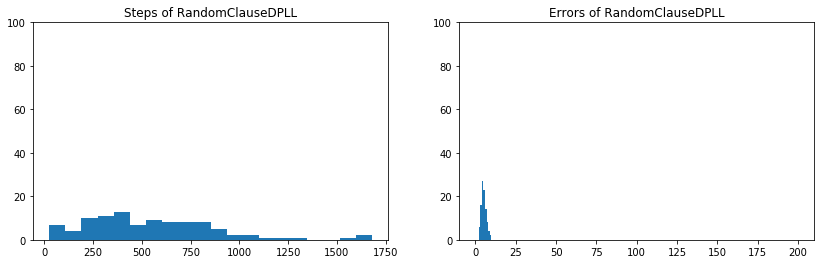

100%|██████████| 100/100 [01:20<00:00,  1.07it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 85.48; stdev step: 191.02; avg error: 0.36; stdev error: 0.99


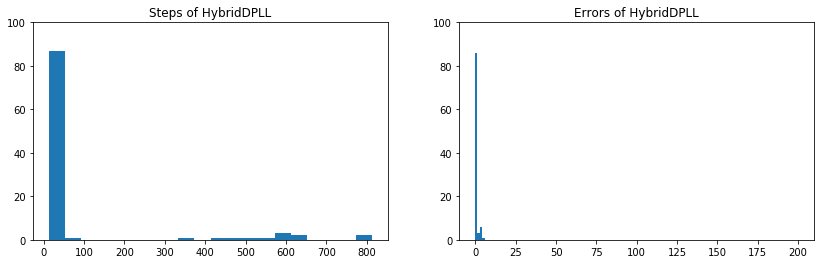

100%|██████████| 100/100 [03:24<00:00,  3.06s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 125.12; stdev step: 317.62; avg error: 0.16; stdev error: 0.42


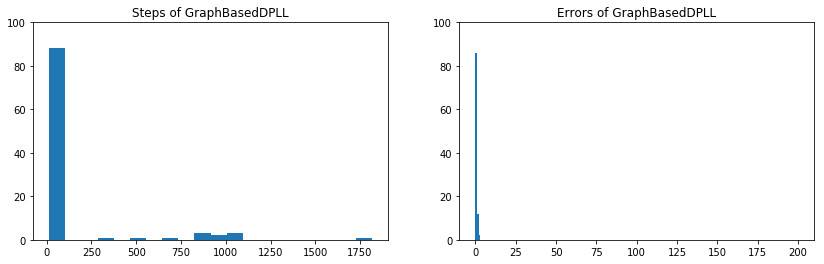

100%|██████████| 100/100 [00:01<00:00, 72.42it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 229.80; stdev step: 191.91; avg error: 2.15; stdev error: 1.28


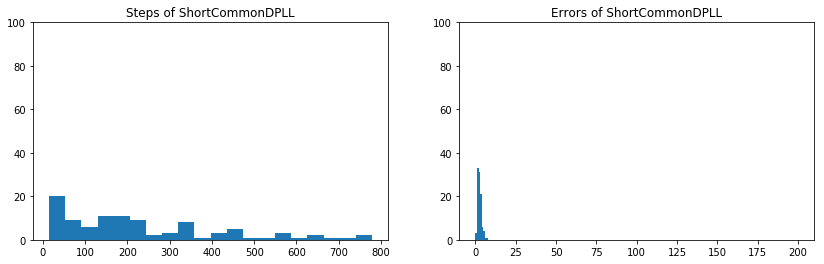

100%|██████████| 100/100 [00:01<00:00, 73.29it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 229.80; stdev step: 191.91; avg error: 2.15; stdev error: 1.28


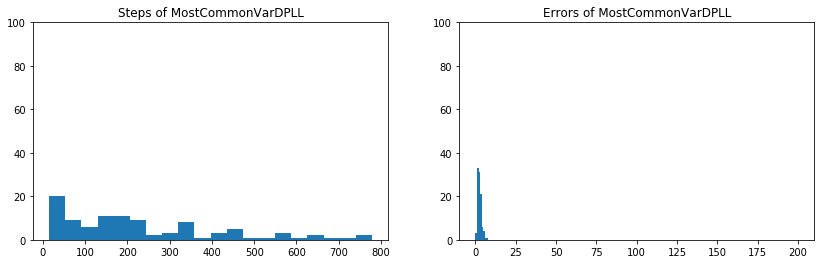

In [42]:
print_all(100, 200, 15)

100%|██████████| 100/100 [00:00<00:00, 503.58it/s]

We have generated 100 formulas


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 65.42; stdev step: 34.78; avg error: 3.77; stdev error: 1.42


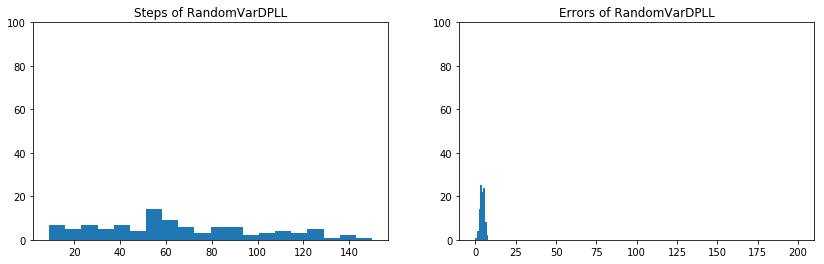

100%|██████████| 100/100 [00:00<00:00, 531.65it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 51.85; stdev step: 34.21; avg error: 2.38; stdev error: 1.27


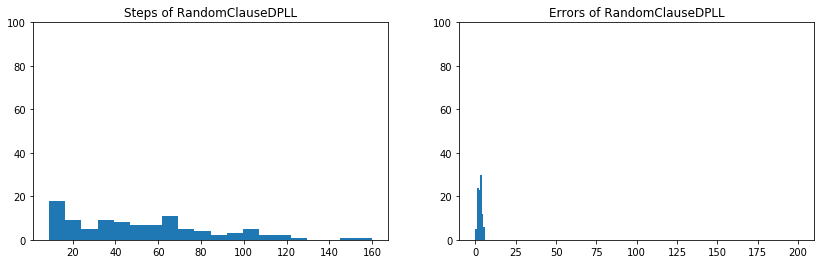

100%|██████████| 100/100 [00:18<00:00,  4.91it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 9.24; stdev step: 2.31; avg error: 0.02; stdev error: 0.14


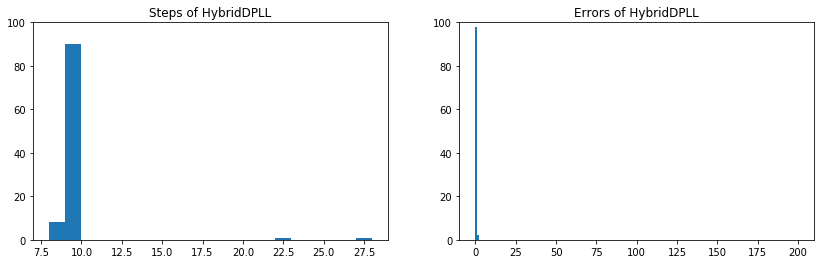

100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 9.24; stdev step: 2.31; avg error: 0.02; stdev error: 0.14


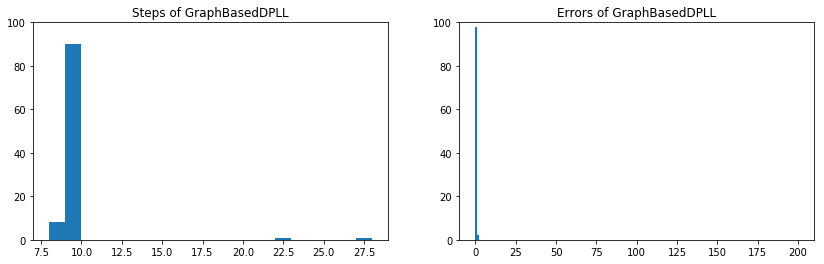

100%|██████████| 100/100 [00:00<00:00, 689.14it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 24.76; stdev step: 18.44; avg error: 1.04; stdev error: 0.88


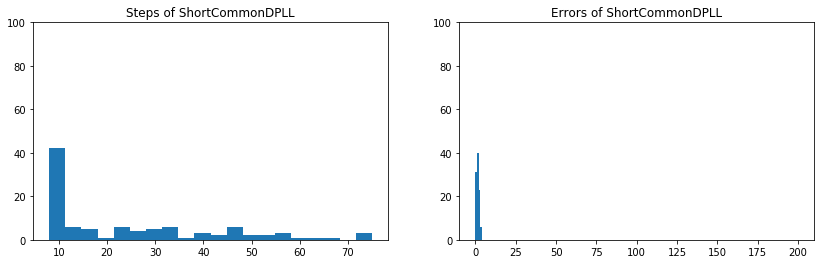

100%|██████████| 100/100 [00:00<00:00, 786.77it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 24.76; stdev step: 18.44; avg error: 1.04; stdev error: 0.88


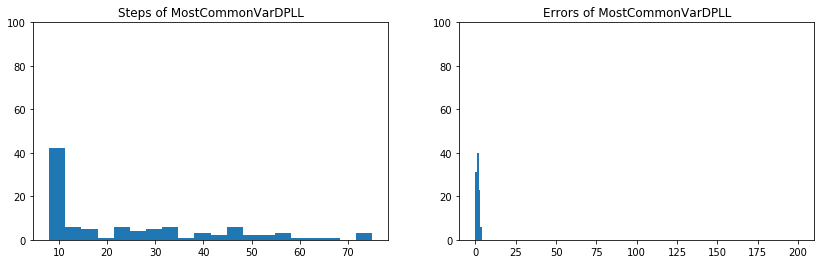

In [43]:
print_all(100, 200, 8)

 41%|████      | 41/100 [00:00<00:00, 189.44it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:00<00:00, 200.10it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 144.76; stdev step: 89.17; avg error: 4.90; stdev error: 1.71


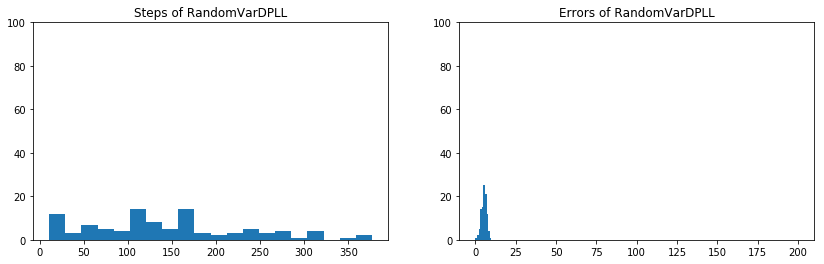

100%|██████████| 100/100 [00:00<00:00, 276.16it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 103.25; stdev step: 70.73; avg error: 2.88; stdev error: 1.46


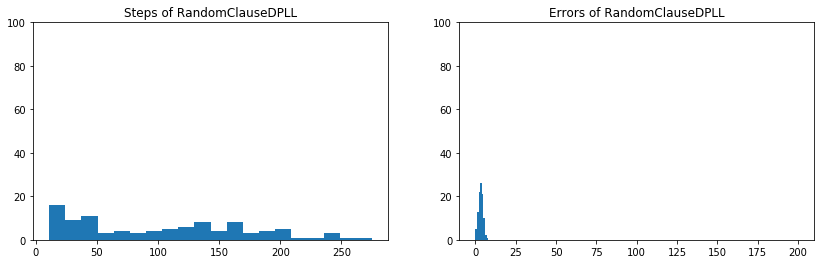

100%|██████████| 100/100 [00:34<00:00,  3.64it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 17.40; stdev step: 28.45; avg error: 0.08; stdev error: 0.31


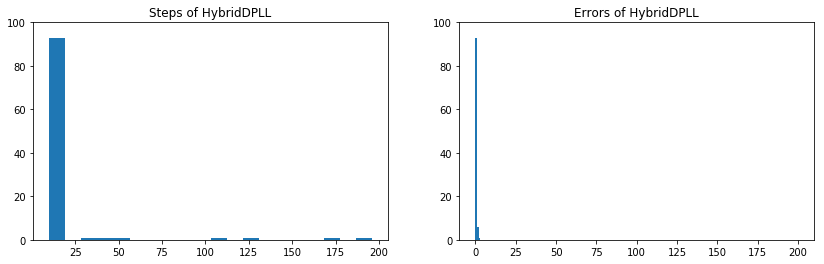

100%|██████████| 100/100 [00:34<00:00,  3.57it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 17.40; stdev step: 28.45; avg error: 0.08; stdev error: 0.31


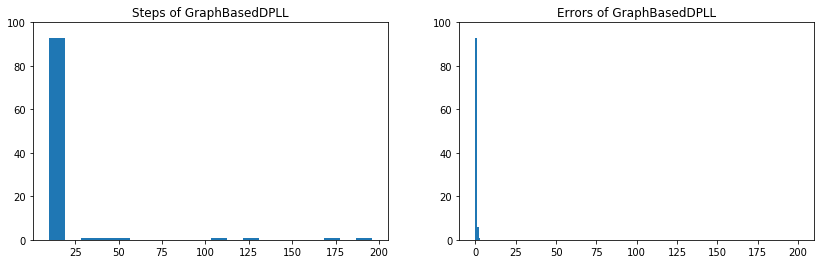

100%|██████████| 100/100 [00:00<00:00, 353.15it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 53.19; stdev step: 43.52; avg error: 1.45; stdev error: 1.05


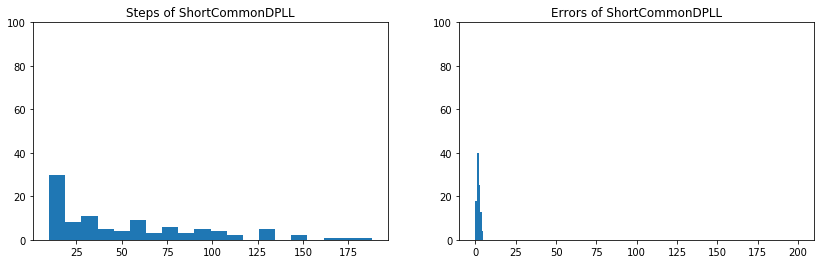

100%|██████████| 100/100 [00:00<00:00, 342.91it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 53.19; stdev step: 43.52; avg error: 1.45; stdev error: 1.05


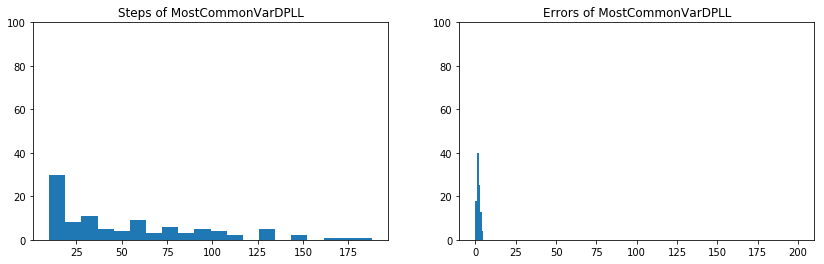

In [44]:
print_all(100, 200, 10)

 24%|██▍       | 24/100 [00:00<00:00, 98.25it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:00<00:00, 99.60it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 270.38; stdev step: 170.59; avg error: 5.99; stdev error: 1.79


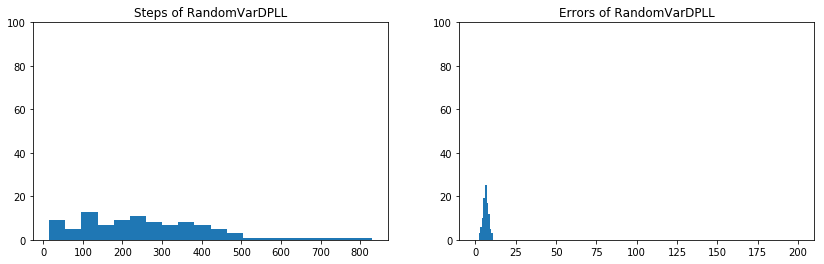

100%|██████████| 100/100 [00:01<00:00, 84.19it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 216.21; stdev step: 136.67; avg error: 3.81; stdev error: 1.35


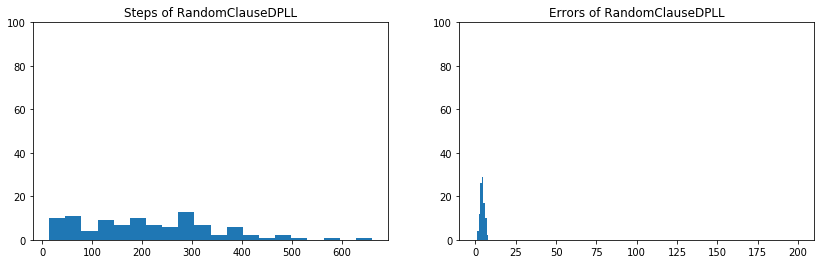

100%|██████████| 100/100 [00:47<00:00,  2.53it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 25.44; stdev step: 48.98; avg error: 0.17; stdev error: 0.62


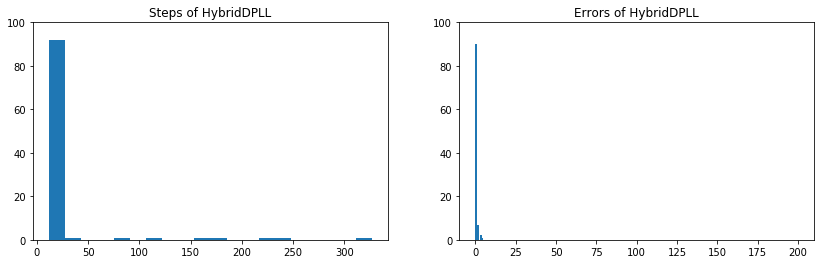

100%|██████████| 100/100 [00:48<00:00,  2.52it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 24.92; stdev step: 45.92; avg error: 0.11; stdev error: 0.34


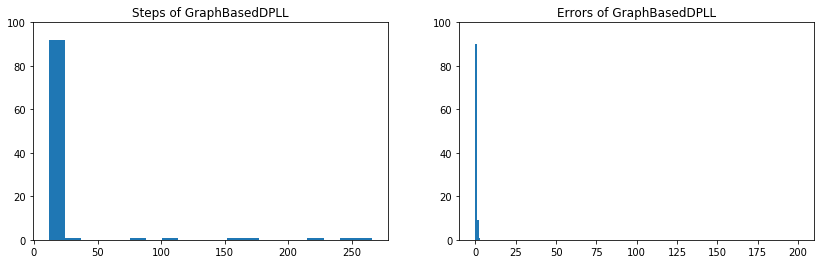

100%|██████████| 100/100 [00:00<00:00, 163.87it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 101.69; stdev step: 81.79; avg error: 1.97; stdev error: 1.04


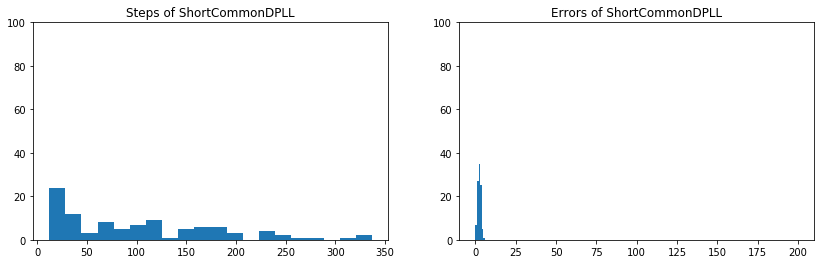

100%|██████████| 100/100 [00:00<00:00, 171.46it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 101.69; stdev step: 81.79; avg error: 1.97; stdev error: 1.04


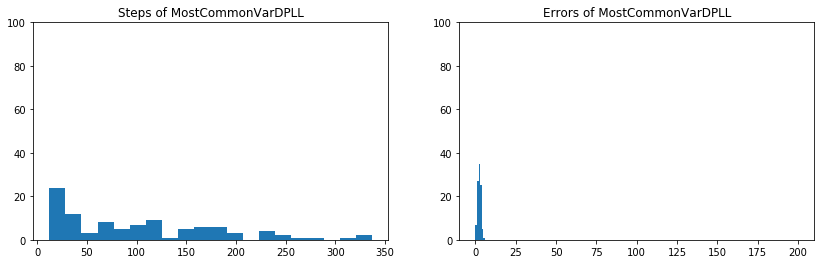

In [45]:
print_all(100, 200, 12)

 10%|█         | 10/100 [00:00<00:02, 41.08it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:02<00:00, 45.15it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 538.62; stdev step: 346.19; avg error: 6.96; stdev error: 2.13


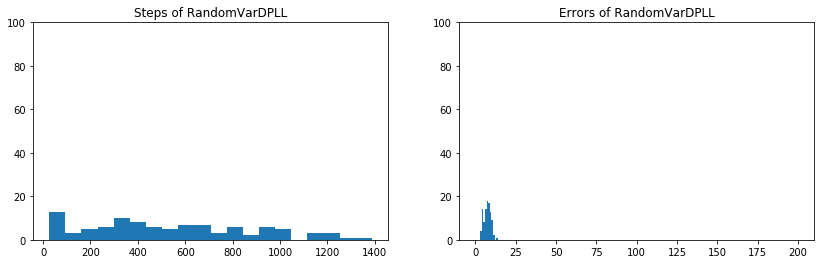

100%|██████████| 100/100 [00:01<00:00, 59.22it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 394.72; stdev step: 259.68; avg error: 4.39; stdev error: 1.73


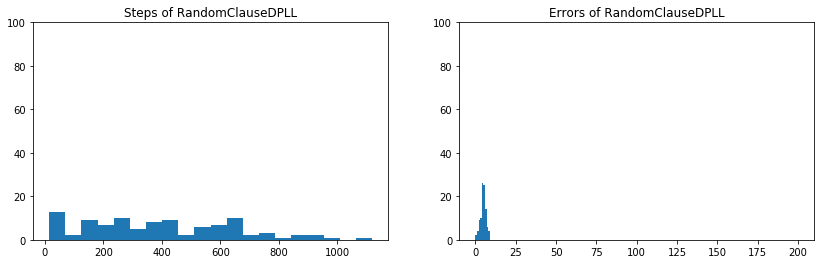

100%|██████████| 100/100 [01:31<00:00,  1.19it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 101.95; stdev step: 179.50; avg error: 0.69; stdev error: 1.42


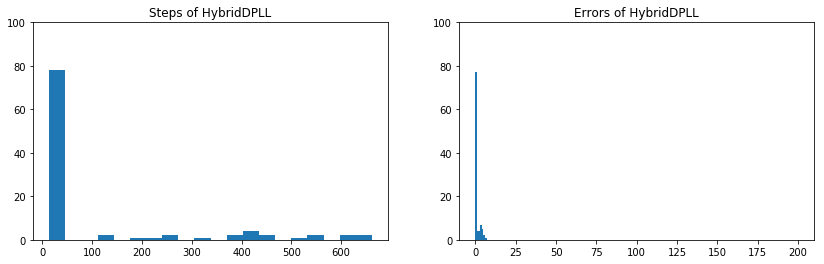

100%|██████████| 100/100 [03:18<00:00,  1.62s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 134.29; stdev step: 268.06; avg error: 0.27; stdev error: 0.53


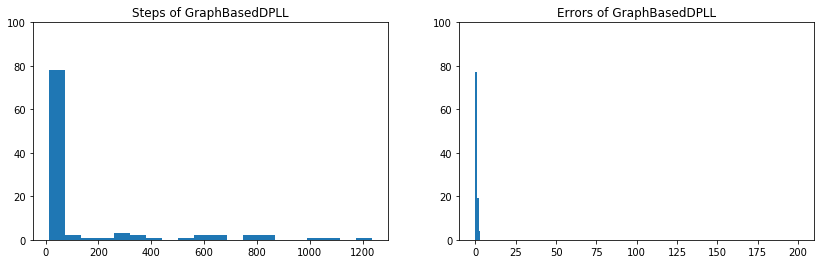

100%|██████████| 100/100 [00:01<00:00, 74.76it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 183.95; stdev step: 156.81; avg error: 2.18; stdev error: 1.25


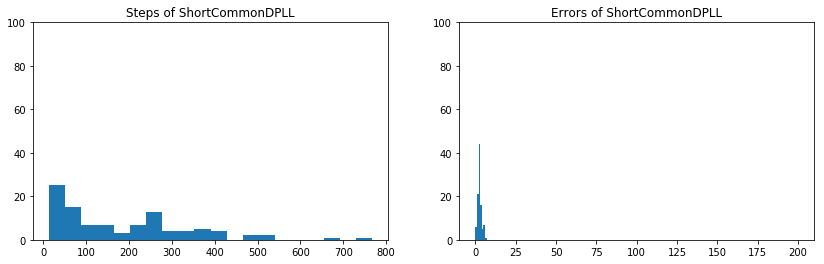

100%|██████████| 100/100 [00:01<00:00, 72.00it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 183.95; stdev step: 156.81; avg error: 2.18; stdev error: 1.25


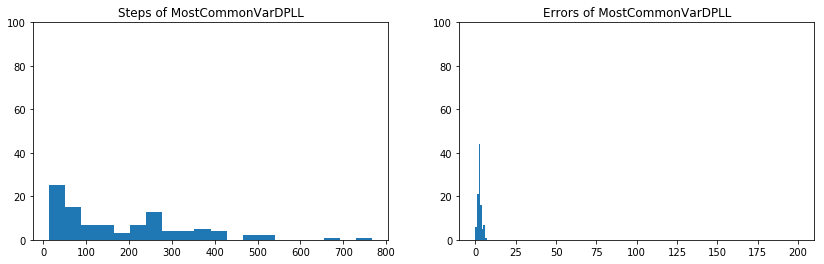

In [46]:
print_all(100, 200, 14)

  3%|▎         | 3/100 [00:00<00:08, 11.28it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:06<00:00, 16.53it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 1167.47; stdev step: 754.61; avg error: 7.68; stdev error: 2.02


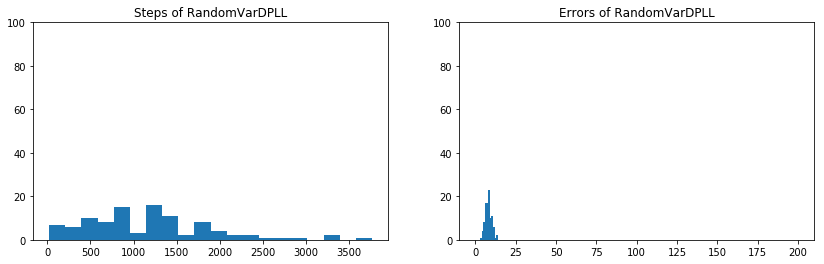

100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 745.63; stdev step: 450.73; avg error: 5.23; stdev error: 1.93


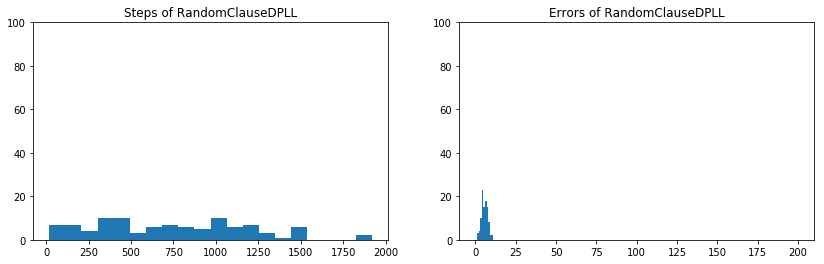

100%|██████████| 100/100 [01:43<00:00,  1.21s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 144.63; stdev step: 286.25; avg error: 0.61; stdev error: 1.21


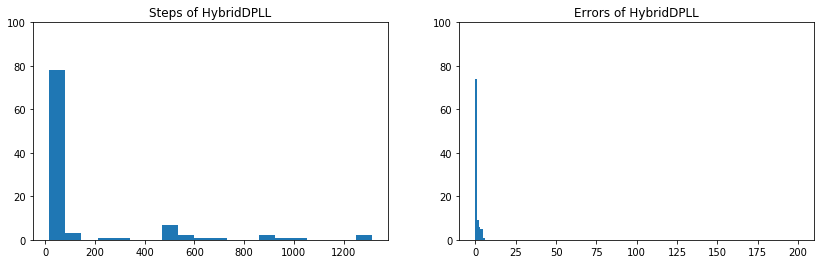

100%|██████████| 100/100 [06:39<00:00,  4.84s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 254.59; stdev step: 547.76; avg error: 0.28; stdev error: 0.49


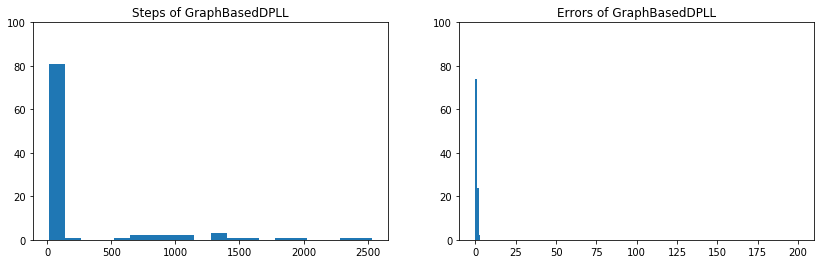

100%|██████████| 100/100 [00:01<00:00, 52.10it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 265.39; stdev step: 245.85; avg error: 2.28; stdev error: 1.35


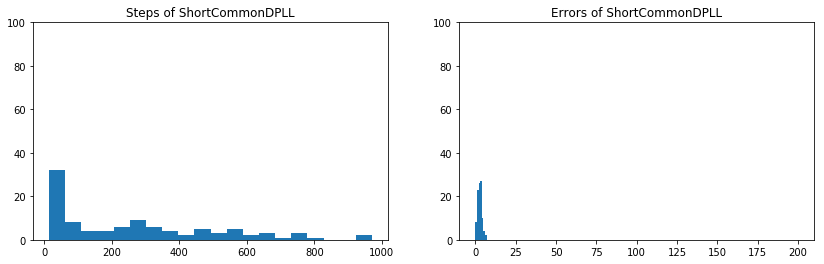

100%|██████████| 100/100 [00:01<00:00, 60.64it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 265.39; stdev step: 245.85; avg error: 2.28; stdev error: 1.35


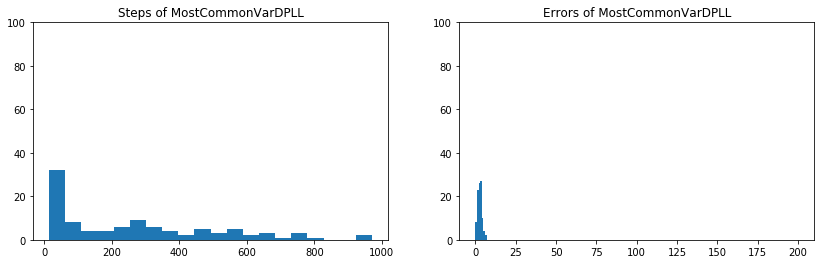

In [47]:
print_all(100, 200, 16)

  3%|▎         | 3/100 [00:00<00:12,  7.90it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 2436.53; stdev step: 1639.57; avg error: 8.37; stdev error: 2.43


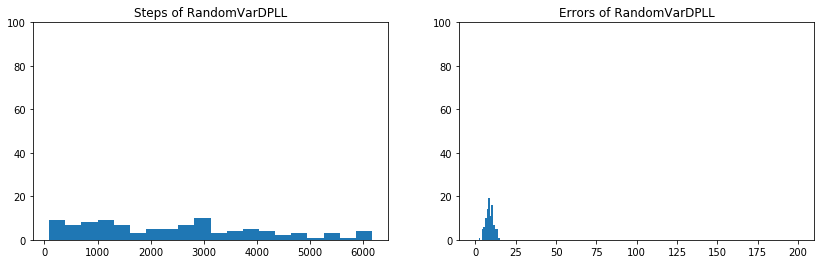

100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 1363.83; stdev step: 934.34; avg error: 5.36; stdev error: 1.74


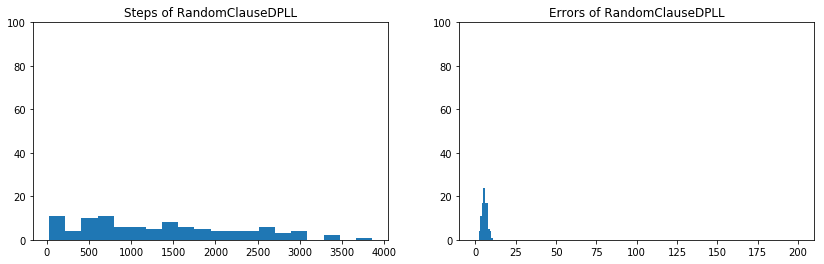

100%|██████████| 100/100 [02:14<00:00,  1.22it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 326.38; stdev step: 586.53; avg error: 0.94; stdev error: 1.54


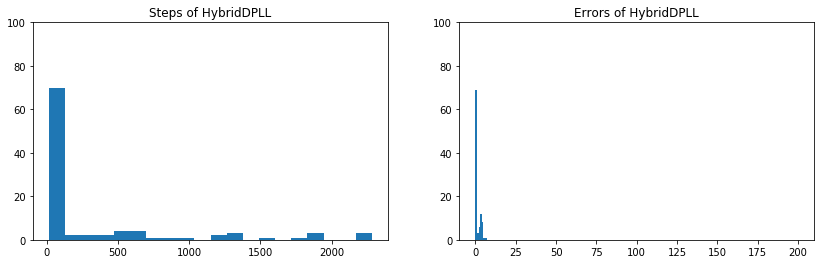

100%|██████████| 100/100 [19:07<00:00,  3.09s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 746.35; stdev step: 1560.85; avg error: 0.37; stdev error: 0.59


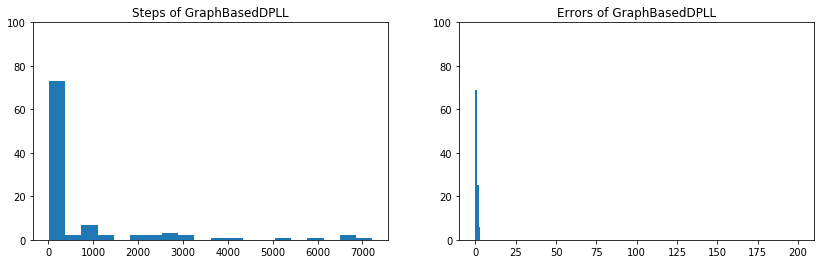

100%|██████████| 100/100 [00:03<00:00, 29.24it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 552.92; stdev step: 505.23; avg error: 2.83; stdev error: 1.48


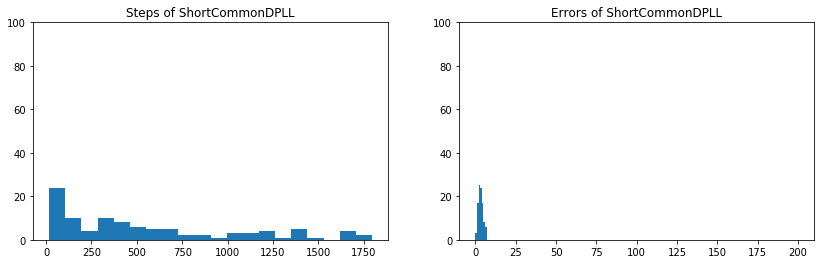

100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 552.92; stdev step: 505.23; avg error: 2.83; stdev error: 1.48


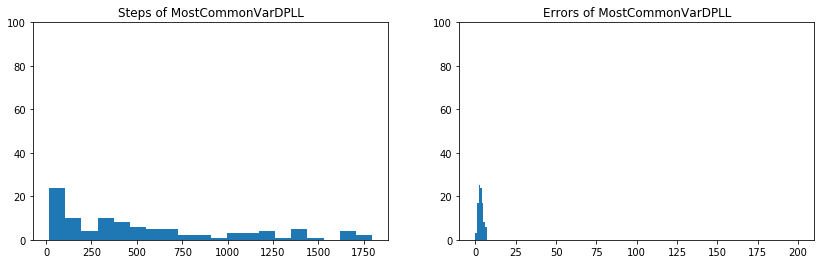

In [48]:
print_all(100, 200, 18)

  1%|          | 1/100 [00:00<00:28,  3.45it/s]

We have generated 100 formulas


100%|██████████| 100/100 [00:25<00:00,  2.66it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 5251.18; stdev step: 3718.99; avg error: 9.50; stdev error: 2.20


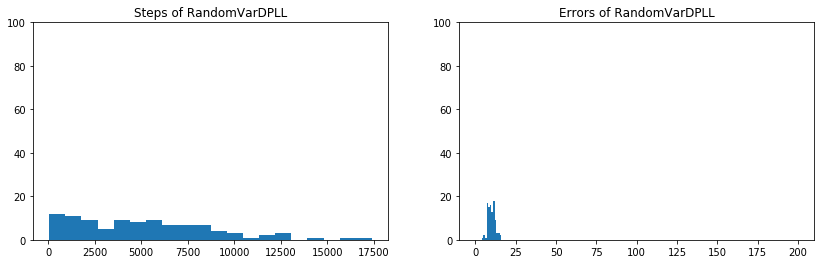

100%|██████████| 100/100 [00:14<00:00,  6.66it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 2788.16; stdev step: 2027.35; avg error: 5.95; stdev error: 2.17


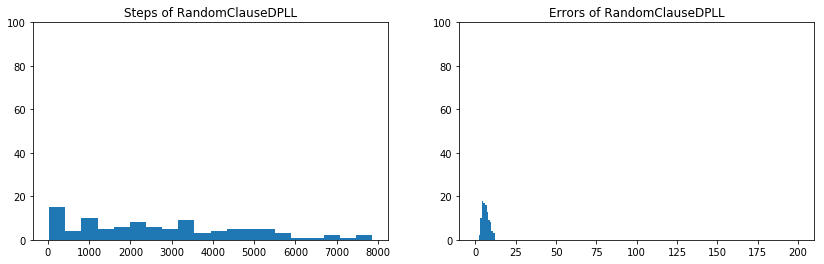

100%|██████████| 100/100 [02:53<00:00,  1.19s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 633.88; stdev step: 912.07; avg error: 1.57; stdev error: 1.99


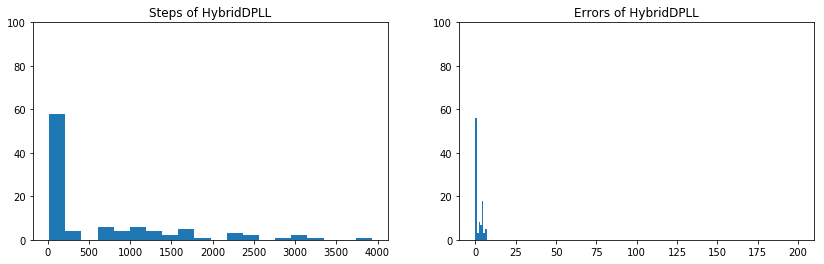

100%|██████████| 100/100 [44:02<00:00,  9.56s/it] 


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 1671.47; stdev step: 2561.47; avg error: 0.54; stdev error: 0.68


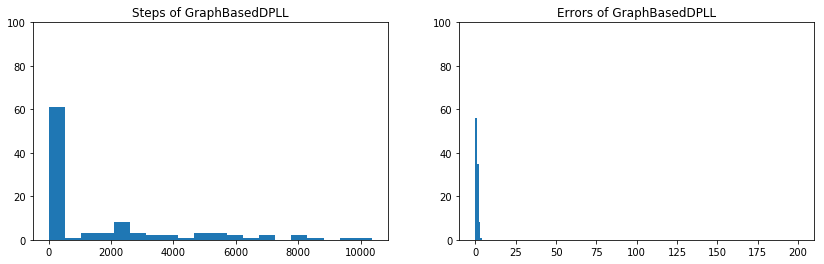

100%|██████████| 100/100 [00:07<00:00, 13.32it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 1153.36; stdev step: 914.69; avg error: 3.51; stdev error: 1.47


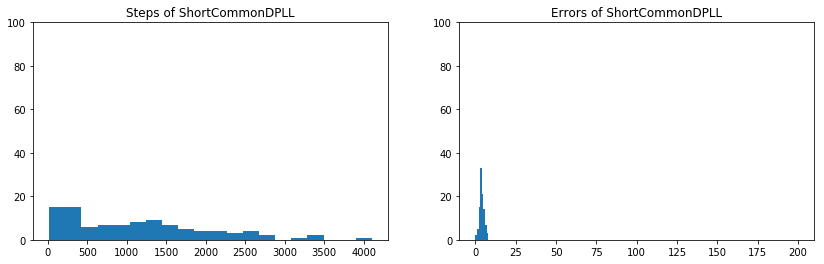

100%|██████████| 100/100 [00:07<00:00, 13.52it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 1153.36; stdev step: 914.69; avg error: 3.51; stdev error: 1.47


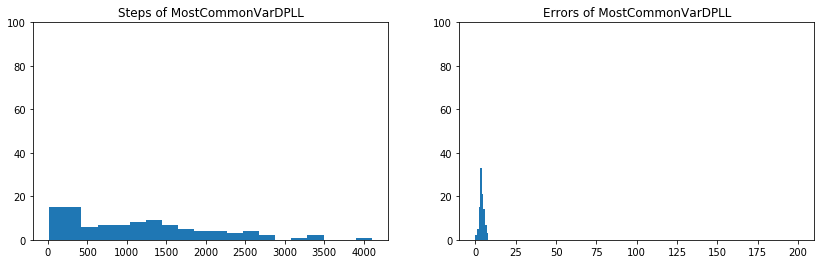

In [49]:
print_all(100, 200, 20)

  1%|          | 1/100 [00:00<01:01,  1.62it/s]

We have generated 100 formulas


100%|██████████| 100/100 [02:36<00:00,  2.39s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 25275.98; stdev step: 16155.07; avg error: 12.27; stdev error: 2.69


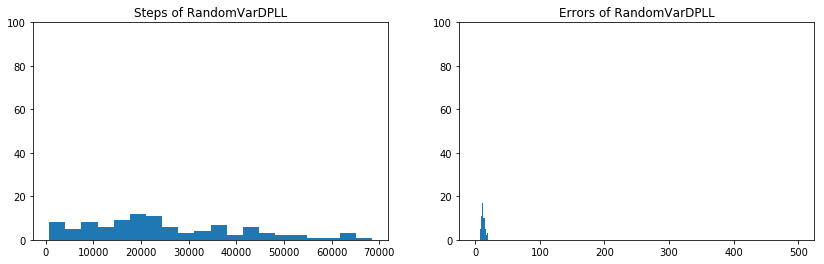

100%|██████████| 100/100 [01:33<00:00,  1.34s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 13385.34; stdev step: 8408.59; avg error: 7.64; stdev error: 2.43


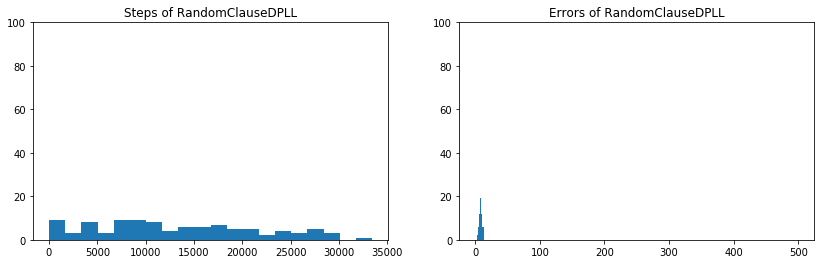

100%|██████████| 100/100 [04:14<00:00,  2.19s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 2601.54; stdev step: 4043.58; avg error: 1.87; stdev error: 2.17


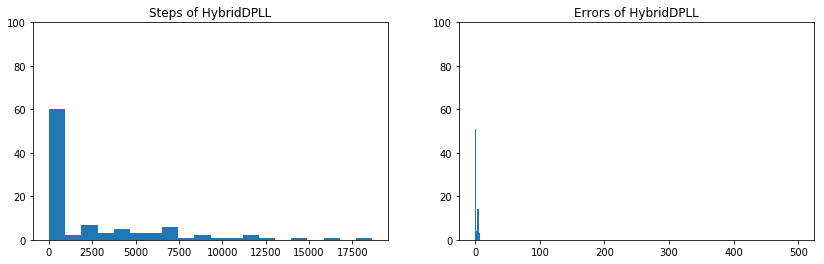

100%|██████████| 100/100 [5:09:50<00:00, 153.11s/it] 


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 10687.70; stdev step: 20495.71; avg error: 0.71; stdev error: 0.88


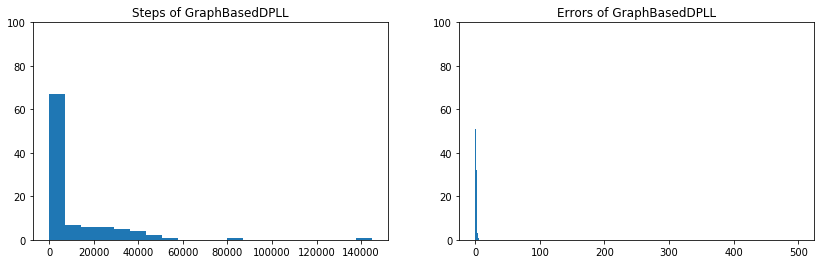

100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 3478.54; stdev step: 3888.89; avg error: 3.67; stdev error: 1.45


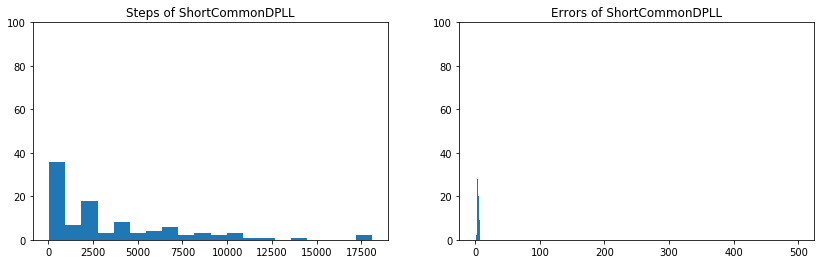

100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 3478.54; stdev step: 3888.89; avg error: 3.67; stdev error: 1.45


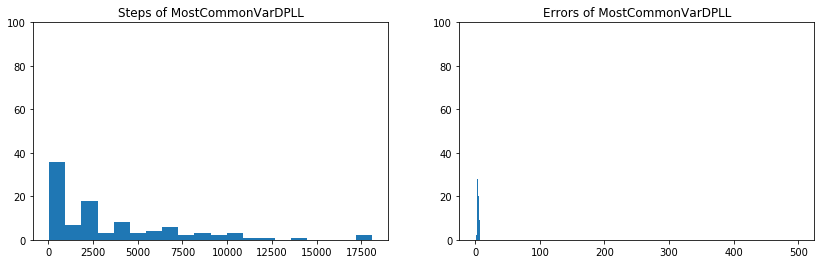

In [50]:
print_all(100, 500, 25)

  1%|          | 1/100 [00:13<22:41, 13.75s/it]

We have generated 100 formulas


100%|██████████| 100/100 [15:33<00:00,  6.45s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 125610.60; stdev step: 99194.34; avg error: 14.64; stdev error: 2.89


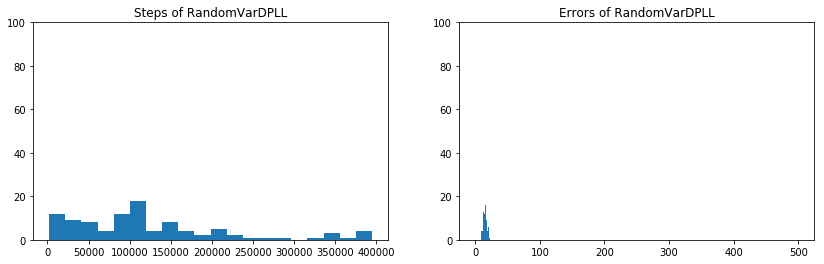

100%|██████████| 100/100 [08:54<00:00,  2.61s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 57509.68; stdev step: 41509.08; avg error: 9.51; stdev error: 2.44


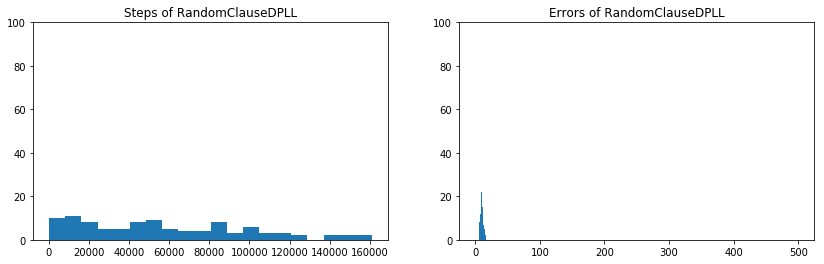

100%|██████████| 100/100 [06:12<00:00,  1.85s/it]


Within 1e6 steps solved 100 problems out of 100
#Sats: 100; avg step: 9560.07; stdev step: 14555.53; avg error: 2.77; stdev error: 2.77


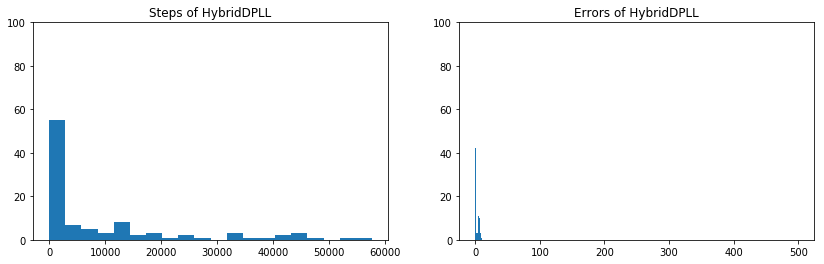

 41%|████      | 41/100 [12:21:44<26:20:33, 1607.34s/it]

KeyboardInterrupt: 

In [51]:
print_all(100, 500, 30, light=True)

In [ ]:
print_all(10, 500, 40, light=True)

In [ ]:
print_all(10, 500, 50, light=True)

In [ ]:
print_all(100, 500, 30, light=True)

In [ ]:
print_all(100, 500, 40, light=True)

In [ ]:
print_all(100, 500, 0, light=True)

In [ ]:
print_all(100, 500, 50, light=True)